# Examples of Realtime Sim Sonification Workflow

In [64]:
import asyncio
import time
import traceback
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.animation as animation
import random
import IPython
from scipy import integrate
from pythonosc.udp_client import SimpleUDPClient
import oscpipe.oscpipe as oscpipe

In [2]:
# Start an OSCPipe to connect to SC
osc = oscpipe.BaseOSCPipe(
    logger=None,
    bind_ip=('localhost', 1337),
    client_ip=('localhost', 57120),
    osc_keepalive_threshold=30,
    outgoing_addr_prefix='/kuramoto',
)

aloop=asyncio.get_event_loop()
osc_server_task = aloop.create_task(osc.run_server(), name="OSC Server Task")
keepalive_osc_task = aloop.create_task(osc.run_osc_keepalive(), name="OSC Keepalive Task")


Not connected to SuperCollider, awaiting auth request ...
Not connected to SuperCollider, awaiting auth request ...
Not connected to SuperCollider, awaiting auth request ...
Not connected to SuperCollider, awaiting auth request ...
Not connected to SuperCollider, awaiting auth request ...


In [40]:
# /python 'sim' simType 't' t_val 'X' [ X1 X2 X3 ... ] 'dX' [ dX1 dX2 dX3 ... ]
await osc.broadcast('sim', ['KuramotoBasic', 't', 0.0, 
                            'X', np.random.rand(20).tolist(), 
                            'dX',np.random.rand(20).tolist()]
                   )
await osc.broadcast('volume', [0.5])

In [37]:
await osc.broadcast('volume', [0.0]) # Silence...

In [183]:
# How to append a multi-D sim datapoint to a multi-D history..
hist = np.atleast_2d(np.zeros(10)).T
print(hist)
for i in range(10):
    ar = np.atleast_2d(np.around(np.linspace(i, i+10, num=10), 2))
    hist = np.append(hist, ar.T, 1)
print(hist)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.    0.    1.    2.    3.    4.    5.    6.    7.    8.    9.  ]
 [ 0.    1.11  2.11  3.11  4.11  5.11  6.11  7.11  8.11  9.11 10.11]
 [ 0.    2.22  3.22  4.22  5.22  6.22  7.22  8.22  9.22 10.22 11.22]
 [ 0.    3.33  4.33  5.33  6.33  7.33  8.33  9.33 10.33 11.33 12.33]
 [ 0.    4.44  5.44  6.44  7.44  8.44  9.44 10.44 11.44 12.44 13.44]
 [ 0.    5.56  6.56  7.56  8.56  9.56 10.56 11.56 12.56 13.56 14.56]
 [ 0.    6.67  7.67  8.67  9.67 10.67 11.67 12.67 13.67 14.67 15.67]
 [ 0.    7.78  8.78  9.78 10.78 11.78 12.78 13.78 14.78 15.78 16.78]
 [ 0.    8.89  9.89 10.89 11.89 12.89 13.89 14.89 15.89 16.89 17.89]
 [ 0.   10.   11.   12.   13.   14.   15.   16.   17.   18.   19.  ]]


In [195]:
# Take the last 3 items from each history and append five zeros to the beginning
cuthist = hist.T[-3:].T
print(cuthist)
print(cuthist.shape)
print(np.append(np.zeros([cuthist.shape[0], 5]), cuthist, 1))

[[ 7.    8.    9.  ]
 [ 8.11  9.11 10.11]
 [ 9.22 10.22 11.22]
 [10.33 11.33 12.33]
 [11.44 12.44 13.44]
 [12.56 13.56 14.56]
 [13.67 14.67 15.67]
 [14.78 15.78 16.78]
 [15.89 16.89 17.89]
 [17.   18.   19.  ]]
(10, 3)
[[ 0.    0.    0.    0.    0.    7.    8.    9.  ]
 [ 0.    0.    0.    0.    0.    8.11  9.11 10.11]
 [ 0.    0.    0.    0.    0.    9.22 10.22 11.22]
 [ 0.    0.    0.    0.    0.   10.33 11.33 12.33]
 [ 0.    0.    0.    0.    0.   11.44 12.44 13.44]
 [ 0.    0.    0.    0.    0.   12.56 13.56 14.56]
 [ 0.    0.    0.    0.    0.   13.67 14.67 15.67]
 [ 0.    0.    0.    0.    0.   14.78 15.78 16.78]
 [ 0.    0.    0.    0.    0.   15.89 16.89 17.89]
 [ 0.    0.    0.    0.    0.   17.   18.   19.  ]]


In [323]:
# Run an async simulation...

sim = type('SinesTest', (), {})()
sim.name = "SinesTest"
sim.n=6 # number of oscillators
sim.phase_gap=0.3 # phase gap between oscillators
sim.frequencies=np.random.rand(sim.n) / 10.0
sim.amplitudes=np.random.rand(sim.n)
sim.t=np.zeros(sim.n)
sim.Xhist=np.atleast_2d(np.zeros(sim.n)).T # History of X values

async def run_sim(sim, num_steps=100, update_every=1):
    try:
        sim.step=0
        sim.t=np.zeros(sim.n)
        print(f"RUN SIM for {num_steps} steps, update every {update_every}s, beginning with step {sim.step} ...")
        startTime = time.time()
        while sim.step < num_steps:
            sim.t = sim.t + sim.frequencies
            X = np.around(np.sin(sim.t), 4) * sim.amplitudes
            dX = np.around(np.cos(sim.t), 4)
            # Append X to Xhist

            sim.Xhist = np.append(sim.Xhist, np.atleast_2d(X).T, 1)
            
            #print(sim.step)
            #print(sim.Xhist)

            # 1. If plot available, add to plot // realtime_plot.update([ys])
            # 2. If osc available, send data to SuperCollider
            if osc is not None:
                await osc.broadcast('sim', ['KuramotoBasic', 't', sim.step, 
                    'X', X.tolist(), 
                    'dX', dX.tolist()]
                )            
            await asyncio.sleep(update_every)
            sim.step += 1
        executionTime = (time.time() - startTime)
        print(f"SIM END after {num_steps} steps and {str(executionTime)} seconds")  
    except Exception as ex:
        traceback.print_exc()
        print(f"Exception: {ex.__class__.__name__}: {str(ex)}")
 

In [325]:
# Run sim
await osc.broadcast('volume', [0.5])

loop=asyncio.get_event_loop()
sim_task=loop.create_task(run_sim(sim, num_steps=5000, update_every=0.1))

RUN SIM for 5000 steps, update every 0.1s, beginning with step 0 ...


In [324]:
try:
    exception = sim_task.exception()
    if exception is not None:
        raise exception
except asyncio.InvalidStateError as e:
    sim_task.cancel()

sim_task.cancel()
await osc.broadcast('volume', [0.0])

<IPython.core.display.Javascript object>


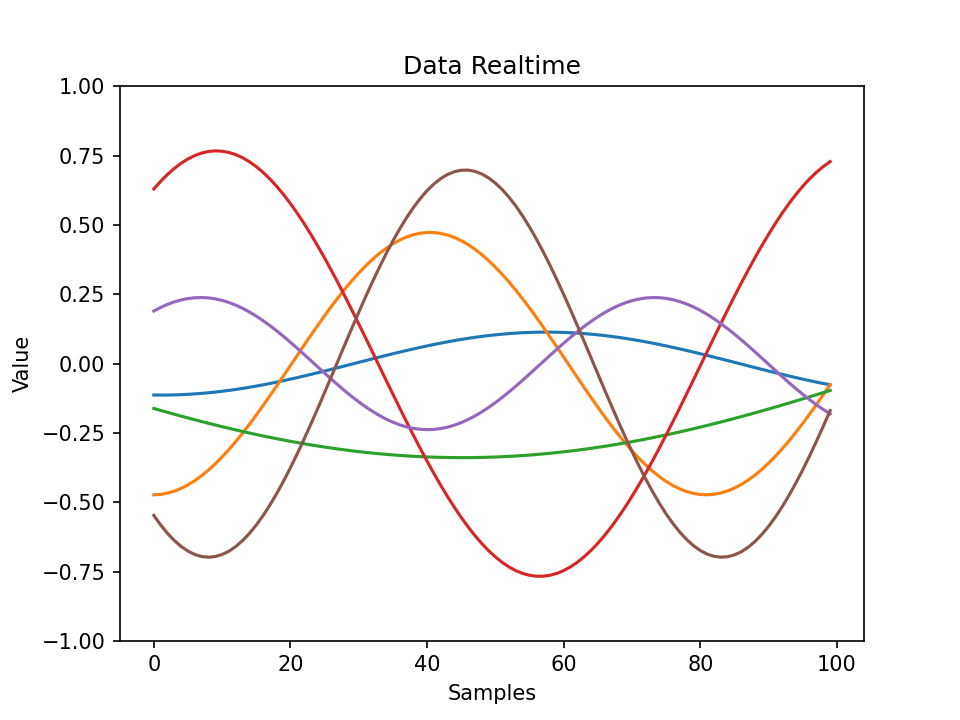

In [327]:
# Create a realtime plot
%matplotlib notebook

plot = type('AnimatedPlot', (), {})()
plot.name = 'AnimatedPlot'
plot.x_len = 100         # Number of points to display
plot.y_range = [-1.0, 1.0]  # Range of possible Y values to display
plot.x_domain = range(0, 200)
plot.n = sim.n
plot.sim = sim # Sim to plot..

# Create figure, subplot and set y domain
plot.fig = plt.figure()
plot.ax = plot.fig.add_subplot(1, 1, 1)
plot.ax.set_ylim(plot.y_range)
# Create a 0 line for each sim oscillaor, We will update the lines in animate
plot.lines = []
for i in range(plot.n):
    line, = plot.ax.plot(range(0, plot.x_len), np.zeros(plot.x_len))
    plot.lines.append(line)

# Add labels
plt.title('Data Realtime')
plt.xlabel('Samples')
plt.ylabel('Value')

# This function is called periodically from FuncAnimation
def plot_animate_frame(i, plot):
    #print(f"Animate!{i} {plot}")
    try:
        # Take the last x_len data points from the sim history
        ys = plot.sim.Xhist.T[-plot.x_len:].T
        padding = plot.x_len - ys.shape[1]
        if padding > 0:
            # Leading buffer with zeros
            ys = np.append(np.zeros([ys.shape[0], padding]), ys, 1)

        # Add y to each list
        for i in range(len(ys)):
            # Update each line
            plot.lines[i].set_ydata(ys[i])

        return plot.lines
    except Exception as ex:
        print(f"GOT ERROR IN ANIMATION LOOP: {ex.__class__.__name__}: {str(ex)}")

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(
    plot.fig,
    plot_animate_frame,
    fargs=(plot,),
    interval=100, # in ms
    blit=True
)

plt.show()

In [313]:
ys = plot.sim.Xhist.T[-plot.x_len:].T
print(ys.shape)
padding = plot.x_len - ys.shape[1]
if padding > 0:
    # Leading buffer with zeros
    ys = np.append(np.zeros([ys.shape[0], padding]), ys, 1)
print(ys.shape)
for idx in range(len(plot.lines)):
    plot.lines[idx].set_ydata(ys[idx])

(5, 200)
(5, 200)
